`matplotlib` magic command (only necessary for `jupyter` notebooks). 

Install and update `cityseer` if necessary.

In [1]:
%matplotlib inline
!pip install --upgrade cityseer

## Quickstart

`cityseer` revolves around networks (graphs). If you're comfortable with `numpy` and abstract data handling, then the
underlying data structures can be created and manipulated directly. However, it is generally more convenient to sketch
the graph using [`NetworkX`](https://networkx.github.io/) and to let `cityseer` take care of initialising and converting
the graph for you.

MultiGraph with 57 nodes and 79 edges 



/var/folders/t_/5c1lfd_94x15tzn6qlb2btk40000gn/T/ipykernel_43421/2476192229.py:7: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G), "\n")


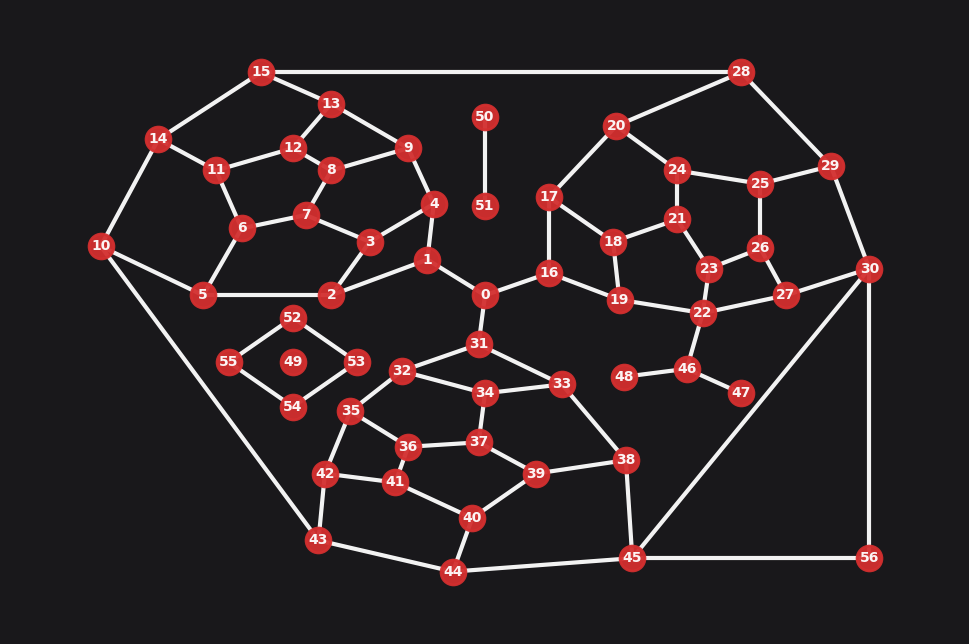

In [7]:
# any networkX MultiGraph with 'x' and 'y' node attributes will do
# here we'll use the cityseer mock module to generate an example networkX graph
import networkx as nx
from cityseer.tools import mock, graphs, plot

G = mock.mock_graph()
print(nx.info(G), "\n")
# let's plot the network
plot.plot_nx(G, labels=True, node_size=80, dpi=200)

The [`tools.graphs`](/tools/graphs/) module contains a collection of convenience functions for the preparation and conversion of `networkX` `MultiGraphs`, i.e. undirected graphs allowing for parallel edges. These functions are designed to work with raw `shapely` [`Linestring`](https://shapely.readthedocs.io/en/latest/manual.html#linestrings) geometries that have been assigned to the edge (link) `geom` attributes. The benefit to this approach is that the geometry of the network is decoupled from the topology: the topology is consequently free from distortions which would otherwise confound centrality and other metrics.

There are generally two scenarios when creating a street network graph:

1. In the ideal case, if you have access to a high-quality street network dataset -- which keeps the topology of the network separate from the geometry of the streets -- then you would construct the network based on the topology while assigning the roadway geometries to the respective edges spanning the nodes. [OS Open Roads](https://www.ordnancesurvey.co.uk/business-and-government/products/os-open-roads.html) is a good example of this type of dataset. Assigning the geometries to an edge involves A) casting the geometry to a [`shapely`](https://shapely.readthedocs.io) `LineString`, and B) assigning this geometry to the respective edge by adding the `LineString` geometry as a `geom` attribute. e.g. `G.add_edge(start_node, end_node, geom=a_linestring_geom)`.

2. In reality, most data-sources are not this refined and will represent roadway geometries by adding additional nodes to the network. For a variety of reasons, this is not ideal and you may want to follow the [`Graph Cleaning`](/guide/#graph-cleaning) guide; in these cases, the [`graphs.nx_simple_geoms`](/tools/graphs/#nx-simple-geoms) method can be used to generate the street geometries, after which several methods can be applied to clean and prepare the graph. For example, [`nx_wgs_to_utm`](/tools/graphs/#nx-wgs-to-utm) aids coordinate conversions; [`nx_remove_dangling_nodes`](/tools/graphs/#nx-remove-dangling-nodes) removes remove roadway stubs, [`nx_remove_filler_nodes`](/tools/graphs/#nx-remove-filler-nodes) strips-out filler nodes, and [`nx-consolidate-nodes`](/tools/graphs/#nx-consolidate-nodes) assists in cleaning-up the network.

## Example

Here, we'll walk through a high-level overview showing how to use `cityseer`. You can provide your own shapely geometries if available; else, you can auto-infer simple geometries from the start to end node of each network edge, which works well for graphs where nodes have been used to inscribe roadway geometries.

In [ ]:
G = graphs.nx_simple_geoms(G)
plot.plot_nx(G, labels=True, node_size=80, plot_geoms=True, dpi=200)

We have now inferred geometries for each edge, meaning that each edge now has an associated `LineString` geometry. Any further manipulation of the graph using the `cityseer.graph` module will retain and further manipulate these geometries in-place.

Once the geoms are readied, we can use tools such as [`nx_decompose`](/tools/graphs/#nx-decompose) for generating granular graph representations and [`nx_to_dual`](/tools/graphs/#nx-to-dual) for casting a primal graph representation to its dual.

In [ ]:
G_decomp = graphs.nx_decompose(G, 50)
plot.plot_nx(G_decomp, plot_geoms=True, labels=False, dpi=200)

In [ ]:
# optionally cast to a dual network
G_dual = graphs.nx_to_dual(G)
# here we are plotting the newly decomposed graph (blue) against the original graph (red)
plot.plot_nx_primal_or_dual(G, G_dual, plot_geoms=False, dpi=200)

## Network Layers

The `networkX` graph can now be transformed into a [`NetworkLayer`](/metrics/networks/#networklayer) by invoking [`NetworkLayerFromNX`](/metrics/networks/#networklayerfromnx). Network layers are used for network centrality computations and also provide the backbone for subsequent landuse and statistical aggregations. They must be initialised with a set of distances $d_{max}$ specifying the maximum network-distance thresholds at which the local centrality methods will terminate.

The [`NetworkLayer.node_centrality`](/metrics/networks/#networklayer-node-centrality) and [`NetworkLayer.segment_centrality`](/metrics/networks/#networklayer-segment-centrality) methods wrap underlying numba optimised functions that compute a range of centrality methods. All selected measures and distance thresholds are computed simultaneously to reduce the amount of time required for multi-variable and multi-scalar workflows. The results of the computations will be written to the `NetworkLayer` class, and can be accessed at the `NetworkLayer.metrics_state` attribute. It is also possible to extract the data to a `python` dictionary through use of the [`NetworkLayer.metrics_to_dict`](/metrics/networks/#networklayer-metrics-to-dict) method, or to simply convert the network — data and all — back into a `networkX` layer with the [`NetworkLayer.to_nx_multigraph`](/metrics/networks/#networklayer-to-nx-multigraph) method.

In [ ]:
from cityseer.metrics import networks

# create a Network layer from the networkX graph
N = networks.NetworkLayerFromNX(G_decomp, distances=[200, 400, 800, 1600])
# the underlying method allows the computation of various centralities simultaneously, e.g.
N.segment_centrality(measures=["segment_harmonic", "segment_betweenness"])

## Data Layers

A [`DataLayer`](/metrics/layers/#datalayer) represents data points. A `DataLayer` can be assigned to a [`NetworkLayer`](/metrics/networks/#networklayer), which means that each data point will be associated with the two closest network nodes — one in either direction — based on the closest adjacent street edge. This enables `cityseer` to use dynamic spatial aggregation methods that more accurately describes distances from the perspective of pedestrians travelling over the network, and relative to the direction of approach.

In [ ]:
from cityseer.metrics import layers

# a mock data dictionary representing the 'x', 'y' attributes for data points
data_dict = mock.mock_data_dict(G_decomp, random_seed=25)
print(data_dict[0], data_dict[1], "etc.")
# generate a data layer
cc_data = layers.DataLayerFromDict(data_dict)
# assign to the prior Network Layer
# max_dist represents the farthest to search for adjacent street edges
cc_data.assign_to_network(N, max_dist=400)
# let's plot the assignments
plot.plot_assignment(N.network_structure, N.nx_multigraph, cc_data.data_map, dpi=200)

Once the data has been assigned, the [`DataLayer.compute_landuses`](/metrics/layers/#datalayer-compute-landuses) method is used for the calculation of mixed-use and land-use accessibility measures whereas [`DataLayer.compute_stats`](/metrics/layers/#datalayer-compute-stats) can likewise be used for statistical measures. As with the centrality methods, the measures are all computed simultaneously (and for all distances); however, simpler stand-alone methods are also available, including [`DataLayer.hill_diversity`](/metrics/layers/#hill-diversity), [`DataLayer.hill_branch_wt_diversity`](/metrics/layers/#hill-branch-wt-diversity), and [`DataLayer.compute_accessibilities`](/metrics/layers/#compute-accessibilities).

Landuse labels can be used to generate mixed-use and land-use accessibility measures. Let's create mock landuse labels for the points in our data dictionary and compute mixed-uses and land-use accessibilities:

In [ ]:
landuse_labels = mock.mock_categorical_data(len(data_dict), random_seed=25)
print(landuse_labels)
# example easy-wrapper method for computing mixed-uses
cc_data.hill_branch_wt_diversity(landuse_labels, qs=[0, 1, 2])
# example easy-wrapper method for computing accessibilities
# the keys correspond to keys present in the landuse data
# for which accessibilities will be computed
cc_data.compute_accessibilities(landuse_labels, accessibility_keys=["a", "c"])
# or compute multiple measures at once, e.g.:
cc_data.compute_landuses(
    landuse_labels, mixed_use_keys=["hill", "hill_branch_wt", "shannon"], accessibility_keys=["a", "c"], qs=[0, 1, 2]
)

We can do the same thing with numerical data. Let's generate some mock numerical data:

In [ ]:
mock_valuations_data = mock.mock_numerical_data(len(data_dict), random_seed=25)
print(mock_valuations_data)
# compute max, min, mean, mean-weighted, variance, and variance-weighted
cc_data.compute_stats("valuations", mock_valuations_data)

The data is aggregated and computed over the street network relative to the `NetworkLayer` (i.e. street) nodes. The mixed-use, accessibility, and statistical aggregations can therefore be compared directly to centrality computations from the same locations, and can be correlated or otherwise compared. The outputs of the calculations are written to the corresponding node indices in the same `NetworkLayer.metrics_state` attribute used for centrality methods, and will be categorised by the respective keys and parameters.

In [ ]:
# access the data arrays at the respective keys, e.g.
distance_idx = 800  # any of the initialised distances
q_idx = 0  # q index: any of the invoked q parameters
# centrality
print("centrality keys:", list(N.metrics_state.centrality.keys()))
print("distance keys:", list(N.metrics_state.centrality["segment_harmonic"].keys()))
print(N.metrics_state.centrality["segment_harmonic"][distance_idx][:4])
# mixed-uses
print("mixed-use keys:", list(N.metrics_state.mixed_uses.keys()))
# here we are indexing in to the specified q_idx, distance_idx
print(N.metrics_state.mixed_uses["hill_branch_wt"][q_idx][distance_idx][:4])
# statistical keys can be retrieved the same way:
print("stats keys:", list(N.metrics_state.stats.keys()))
print("valuations keys:", list(N.metrics_state.stats["valuations"].keys()))
print("valuations weighted by 1600m decay:", N.metrics_state.stats["valuations"]["mean_weighted"][1600][:4])
# the data can also be convert back to a NetworkX graph
G_metrics = N.to_nx_multigraph()
print(nx.info(G_metrics))
# the data arrays are unpacked accordingly
print(G_metrics.nodes[0]["metrics"]["centrality"]["segment_betweenness"][200])
# and can also be extracted to a dictionary:
G_dict = N.metrics_to_dict()
print(G_dict[0]["centrality"]["segment_betweenness"][200])

The data can then be passed to data analysis or plotting methods. For example, the [`tools.plot`](/tools/plot/) module can be used to plot the segmentised harmonic closeness centrality and mixed uses for the above mock data:

In [ ]:
# plot centrality
from matplotlib import colors

segment_harmonic_vals = []
mixed_uses_vals = []
for node, data in G_metrics.nodes(data=True):
    segment_harmonic_vals.append(data["metrics"]["centrality"]["segment_harmonic"][800])
    mixed_uses_vals.append(data["metrics"]["mixed_uses"]["hill_branch_wt"][0][400])
# custom colourmap
cmap = colors.LinearSegmentedColormap.from_list("cityseer", ["#64c1ff", "#d32f2f"])
# normalise the values
segment_harmonic_vals = colors.Normalize()(segment_harmonic_vals)
# cast against the colour map
segment_harmonic_cols = cmap(segment_harmonic_vals)
# plot segment_harmonic
plot.plot_nx(G_metrics, labels=False, node_colour=segment_harmonic_cols, dpi=200)

In [ ]:
# plot distance-weighted hill mixed uses
mixed_uses_vals = colors.Normalize()(mixed_uses_vals)
mixed_uses_cols = cmap(mixed_uses_vals)
plot.plot_assignment(
    N.network_structure,
    N.nx_multigraph,
    cc_data.data_map,
    node_colour=mixed_uses_cols,
    data_labels=landuse_labels,
    dpi=200,
)